# Pairwise distance problem

Consider the problem of finding the pairwise distance of a set of `M` points in
an `N`-dimensional euclidean space.

# Pure Python implementation

The pure python implementation of the function requires two nested for loops.

It is very slow due to the high quanityt type checks done by the python interpreter.

In [1]:
from typing import List
import numpy as np
def pairwise_python(x: np.ndarray) -> np.ndarray:
    # numpy array are used to allow advanced indexing
    m = x.shape[0]
    n = x.shape[1]
    dist = np.empty((m, m), dtype=np.float32)
    for i in range(m):
        for j in range(m):
            d = 0.0
            for k in range(n):
                tmp = x[i, k] - x[j, k]
                d += tmp * tmp
            dist[i, j] = np.sqrt(d)
    return dist

In [2]:
x = np.random.random((1000,3))

In [3]:
%timeit pairwise_python(x)

3.24 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# NumPy implementation

Numpy is internally written in C and provides optimized functions for manipulating arrays.

The pairwise distance implementation is very simple (one liner) and fast.

The main drawback consists in the high memory footprint of this solution: it needs to store
the intermediate results inside an $N*M^2$ matrix.

In [4]:
# 1.24.3 numpy version
import numpy as np

def pairwise_numpy(x: np.ndarray) -> np.ndarray:
    return np.sqrt(((x[:, None, :] - x) ** 2).sum(-1))


In [5]:
x = np.random.random((1000,3))
%timeit pairwise_numpy(x)

54.1 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Numba

[Numba](http://numba.pydata.org/) introduces a JIT compilation step before the
code gets interpreted by the python compiler:

```text
source code -> LLVM compiler -> bytecode -> interpreter -> machine code
```

The Numba LLVM compiler compiles the critic code before running.

The compilation step guarantees orders of magnitude of speed-up.

This is achieved as simply as adding a `@jit` decorator on top of the relevant code block.

:warning: Note that the source code should be compiled the first time it runs.  
When compiling `for` loops, a little overhead on the first iteration is expected.



In [6]:
from numba import njit

pairwise_numba = njit(pairwise_python)

%timeit pairwise_numba(x)

7.1 ms ± 830 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Scipy

In [7]:
from scipy.spatial.distance import cdist
%timeit cdist(x, x)

3.65 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Scikit-learn

In [8]:
from sklearn.metrics import euclidean_distances
%timeit euclidean_distances(x, x)

14.6 ms ± 592 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Tensorflow

This tensorflow implementation is similar to the NumPy one since it uses broadcasting.

Note that tensorflow is not that user friendly when looping over dynamic sized arrays.

In [9]:
import tensorflow as tf

@tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
def pairwise_tf(A): 
    expanded_a = tf.expand_dims(A, 1)
    expanded_b = tf.expand_dims(A, 0)
    distances = tf.reduce_sum(tf.math.squared_difference(expanded_a, expanded_b), 2)
    return distances

2023-05-23 19:02:40.842695: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
%timeit pairwise_tf(tf.constant(x, dtype=tf.float32))

9.49 ms ± 158 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Plot results

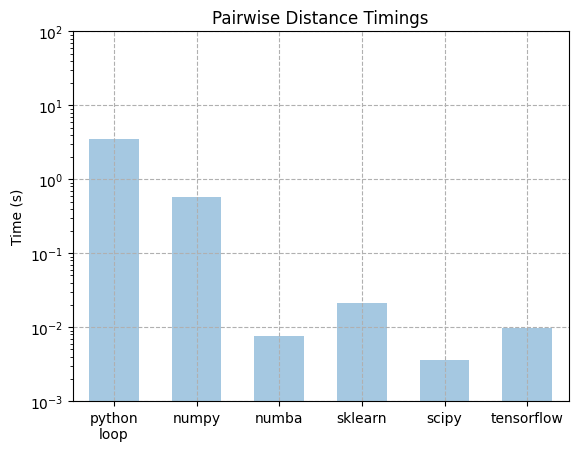

In [11]:
import matplotlib.pyplot as plt
labels = ['python\nloop', 'numpy', 'numba', 'sklearn', 'scipy', 'tensorflow']
timings = [3.55, 0.581, 0.00753, 0.021, 0.00365, 0.00978]
errors = [0.209, 5.27e-6, 1.75e-3, 6.44e-3, 2.01e-4, 3.02e-4]
x = np.arange(len(labels))

ax = plt.axes(xticks=x, yscale='log')
ax.bar(x, timings, width=0.6, alpha=0.4, bottom=1e-6)
ax.grid(linestyle="dashed")
ax.set_xlim(-0.5, len(labels) - 0.5)
ax.set_ylim(1E-3, 1E2)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda i, loc: labels[int(i)]))
ax.set_ylabel('Time (s)')
ax.set_title("Pairwise Distance Timings\nNum points: 1e3, Num dimensions: 3")
plt.show()